# Assignment 6: Neural Networks
## Christopher Rico
## MSDS 422

You will compete in the Kaggle.com Digit Recognizer competition which involves classical digit recognition from hand-written images https://www.kaggle.com/c/digit-recognizer/

Read the competition rules, and download the MNIST training and test set data.This binary classification task is NOT what is required for the current assignment. In this assignment we are asking for a multiclass classifier. The entire MNIST data set will be used for input data. Python TensorFlow should be used for Assignment 6. (If you experience difficulty installing TensorFlow, Python scikit-learn may be used as an alternative for Assignment 6.)

TensorFlow Documentation for this assignment:
*   https://www.tensorflow.org/api_docs/python
*   https://www.tensorflow.org/tutorials/index.html

---





# Ingest

Environment Setup

In [0]:
#--------------------------------------------------------------------
#                       Dev Environment Setup
#--------------------------------------------------------------------
# import base packages into the namespace for this program
from google.colab import files
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import os
import logging
import tensorflow as tf

# turn off those annoying info logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Utility functions

In [0]:
#--------------------------------------------------------------------
#                       Utility Functions
#--------------------------------------------------------------------
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# output predictions to kaggle-formatted csv
def pred_output(filename, preds):
  #create the output file
  rf_out = open(filename, "w")
  rf_out.write("ImageId,Label\n")

  #save the predictions to it
  for index, prediction in enumerate(preds, 1):
    rf_out.write( "{},{}\n".format(index, prediction) )

  #download csv and close the filestream
  files.download(filename)
  rf_out.close()


Getting and Examining Data

In [0]:
#--------------------------------------------------------------------
#                     Getting and Examining Data
#--------------------------------------------------------------------
# Adapted from https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# Run this cell and select the kaggle.json file

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"christophrico","key":"950c6f1b242d7d9159426efd8bd9cdcb"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# now download the MNIST datasets using the kaggle API
!kaggle competitions download -c digit-recognizer

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# get the training set into an x and y dataframe
train_data = pd.read_csv('train.csv')
X_train, y_train = train_data.loc[:,'pixel0':], train_data['label']

In [0]:
X_train.head()

In [0]:
y_train.head()

In [0]:
# get the test set into a dataframe
X_test = pd.read_csv('test.csv')
X_test.head()

In [0]:
# now we get each ones into a list to fit the desired TF input
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values

In [0]:
# reshape the data to play nice :)
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)

# EDA


---



Training data shape {} (42000, 784)


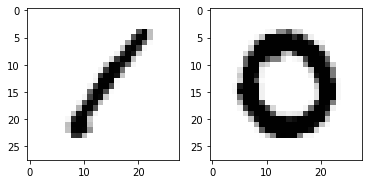

In [0]:
# let's have a look at some of the handwritten digits
print("Training data shape {}", format(X_train.shape))
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

# Modeling


---



In [0]:
# make a dataframe to store results in
results = pd.DataFrame(columns=[
                                'Number of Layers',
                                'Nodes per Layer',
                                'Processing Time',
                                'Training Set Accuracy',
                                ])

In [0]:
#--------------------------------------------------------------------
#                     Neural Net Topology Comparison
#--------------------------------------------------------------------
num_layers = [2, 5]
nodes_per_layer = [10, 20]
n_inputs = 28*28  # MNIST image size

#loop to automate testing neural networks
#with various numbers of layers and nodes
for layer in num_layers:
  for node in nodes_per_layer:  
    # clear any neural net that may already exist
    reset_graph()

    # build the shape of the input matrix
    feature_cols = [tf.feature_column.numeric_column("X", shape=n_inputs)]

    # build the network itself
    n_nodes_layers = [node] * layer
    dnn_clf = tf.estimator.DNNClassifier(
                                         hidden_units=n_nodes_layers,
                                         n_classes=10,
                                         feature_columns=feature_cols
                                        )
    
    # build the input function to get train data in
    input_fn = tf.estimator.inputs.numpy_input_fn(
                                                  x={"X" : X_train},
                                                  y=y_train,
                                                  num_epochs=50,
                                                  batch_size=50,
                                                  shuffle=True
                                                  )
    
    # fit the network and time it
    start = timer()
    dnn_clf.train(input_fn=input_fn)
    end = timer()
    train_time = ("{:.2f}".format(end-start))

    # evaluate training accuracy
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
                                                        x={"X" : X_train},
                                                        y=y_train,
                                                        shuffle=False
                                                        )
    eval_results_train = dnn_clf.evaluate(input_fn=train_input_fn)
    
    # make predictions on test set
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
                                                       x={"X": X_test},
                                                       shuffle=False
                                                       )
    raw_predictions = dnn_clf.predict(input_fn=test_input_fn)
    predictions = [p['class_ids'][0] for p in raw_predictions]


    # save predictions to csv for kaggle
    file_name = "dnn_{}_{}.csv".format(str(layer), str(node))
    pred_output(file_name, predictions)


    # save to results
    results = results.append({
                            'Number of Layers' : layer,
                            'Nodes per Layer' : node,
                            'Processing Time' : train_time,
                            'Training Set Accuracy' : eval_results_train['accuracy']},
                            sort=False,
                            ignore_index=True
                            )
#END LOOPS

Because we're using Colab, the output CSV files have been saved in a Google tmp drive... kinda awkward to get at them, but we'll manage.

In [0]:
# check out local files for csv output
!ls

 dnn_2_10.csv   dnn_5_20.csv	   predictions.csv	   test.csv
 dnn_2_20.csv  'kaggle (1).json'   sample_data		   train.csv
 dnn_5_10.csv   kaggle.json	   sample_submission.csv


In [0]:
# and download the output, finally
files.download("dnn_2_10.csv")
files.download("dnn_2_20.csv")
files.download("dnn_5_10.csv")
files.download("dnn_5_20.csv")

Once we download these output CSV files, they need to be submitted to Kaggle for scoring.

In [0]:
# add in test scores from kaggle
kaggle_scores = [0.9373, 0.9484, 0.9077, 0.9506]
results['Test Set Accuracy'] = kaggle_scores

# Conclusion


---



In [0]:
display(results)

,Number of Layers,Nodes per Layer,Processing Time,Training Set Accuracy,Test Set Accuracy
0,2,10,79.97,0.921809,0.9373
1,2,20,88.16,0.984833,0.9484
2,5,10,90.47,0.815167,0.9077
3,5,20,102.65,0.972143,0.9506


While speed and accuracy results are similar across NN topologies, recommend the network with 5 layers and 20 nodes per layer because it shows the highest accuracy of all four tested while still maintaining an acceptable processing time.